In [1]:
import os
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Sequential, datasets, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import keras.src.saving
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Task 1: Import images with labels and print in a tabular format
data_folder = "/home/dhawi/Documents/dataset"
dataset = data_folder + "/AI_project"
model_folder = "/home/dhawi/Documents/model"
history_folder = "/home/dhawi/Documents/History"

In [4]:
from keras import ops
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [5]:
def generate_images(generator, num_images):
    noise = tf.random.normal((num_images, 1024, 1))
    generated_images = generator.predict(noise)
    # generated_images = (generated_images * 127.5 + 127.5).astype(np.uint8)  # Rescale to [0, 255]
    return generated_images

In [6]:
caries_gan_generator = keras.src.saving.load_model(model_folder + "/fyp_caries_GAN1024_encoder.h5", compile=False)
gingivitis_gan_generator = keras.src.saving.load_model(model_folder + "/fyp_gingivitis_GAN1024_encoder.h5", compile=False)
wsl_gan_generator = keras.src.saving.load_model(model_folder + "/fyp_wsls_GAN1024_encoder.h5", compile=False)

In [7]:
num_images_to_generate = 10

generated_caries_images = generate_images(caries_gan_generator, num_images_to_generate)
generated_gingivitis_images = generate_images(gingivitis_gan_generator, num_images_to_generate)
generated_wsl_images = generate_images(wsl_gan_generator, num_images_to_generate)

I0000 00:00:1717128628.956306   14159 service.cc:145] XLA service 0x7b5568003ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717128628.956327   14159 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


I0000 00:00:1717128629.645851   14159 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


In [8]:
# Load the trained ResNet model
trained_resnet_model = tf.keras.models.load_model('best_model.keras')

def classify_images(model, images):
    predictions = model.predict(images)
    confidences = np.max(predictions, axis=1)
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels, confidences

In [9]:
# Classify the generated images
caries_labels, caries_confidences = classify_images(trained_resnet_model, generated_caries_images)
gingivitis_labels, gingivitis_confidences = classify_images(trained_resnet_model, generated_gingivitis_images)
wsl_labels, wsl_confidences = classify_images(trained_resnet_model, generated_wsl_images)

I0000 00:00:1717128637.593043   14300 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1686', 460 bytes spill stores, 348 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [10]:
fixed_noise = tf.random.normal((60, 1024,1))

In [11]:
def show_images(images):
    for i in range(4):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step


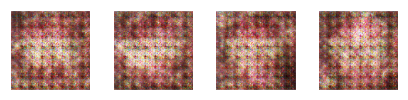

In [12]:
y_pred = caries_gan_generator.predict(fixed_noise)
show_images(y_pred)

In [13]:
trained_resnet_model.predict(generated_caries_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[0.21728677, 0.37533998, 0.40737325],
       [0.21829998, 0.37563568, 0.4060644 ],
       [0.2177197 , 0.3756512 , 0.40662915],
       [0.21824723, 0.37652427, 0.40522844],
       [0.2197707 , 0.3767839 , 0.40344533],
       [0.21704407, 0.37782118, 0.40513483],
       [0.2179612 , 0.37488332, 0.40715557],
       [0.21787089, 0.3756008 , 0.40652832],
       [0.219774  , 0.37566602, 0.40456003],
       [0.21856782, 0.3775659 , 0.40386632]], dtype=float32)

In [14]:
trained_resnet_model.predict(generated_gingivitis_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([[0.22083431, 0.37605444, 0.40311125],
       [0.22207871, 0.37445948, 0.4034618 ],
       [0.22093192, 0.373219  , 0.40584907],
       [0.2202424 , 0.37366426, 0.40609342],
       [0.2226948 , 0.37571496, 0.40159023],
       [0.22049707, 0.37268654, 0.40681642],
       [0.22048853, 0.37378287, 0.40572858],
       [0.22176854, 0.37477988, 0.40345162],
       [0.22032519, 0.37379596, 0.40587887],
       [0.22033374, 0.3744829 , 0.40518337]], dtype=float32)

In [15]:
trained_resnet_model.predict(generated_wsl_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


array([[0.22127178, 0.3741247 , 0.4046035 ],
       [0.22101088, 0.37173927, 0.4072498 ],
       [0.22209953, 0.37441614, 0.40348434],
       [0.221329  , 0.3734813 , 0.40518963],
       [0.22046125, 0.3719857 , 0.40755308],
       [0.22173838, 0.37312883, 0.40513283],
       [0.22273892, 0.3739919 , 0.40326917],
       [0.22171332, 0.3726926 , 0.40559405],
       [0.22093545, 0.37191495, 0.40714964],
       [0.21884407, 0.3747921 , 0.40636382]], dtype=float32)

In [16]:
caries_confidences

array([0.40737325, 0.4060644 , 0.40662915, 0.40522844, 0.40344533,
       0.40513483, 0.40715557, 0.40652832, 0.40456003, 0.40386632],
      dtype=float32)

In [17]:
wsl_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [18]:
caries_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [19]:
confidence_threshold = 0.60  # Example threshold, adjust based on your needs

def filter_images(images, labels, confidences, true_label, threshold):
    mask = (labels == true_label) & (confidences >= threshold)
    return images[mask]

In [20]:
filtered_caries_images = filter_images(generated_caries_images, caries_labels, caries_confidences, 0, confidence_threshold)
filtered_gingivitis_images = filter_images(generated_gingivitis_images, gingivitis_labels, gingivitis_confidences, 1, confidence_threshold)
filtered_wsl_images = filter_images(generated_wsl_images, wsl_labels, wsl_confidences, 2, confidence_threshold)

In [21]:
filtered_caries_images.shape, filtered_gingivitis_images.shape, filtered_wsl_images.shape

((0, 128, 128, 3), (0, 128, 128, 3), (0, 128, 128, 3))

In [22]:
import os
# Function to get image file paths and corresponding labels
def get_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for sub_dir in os.listdir(class_dir):
                sub_dir_path = os.path.join(class_dir, sub_dir)
                if os.path.isdir(sub_dir_path):
                    for img_name in os.listdir(sub_dir_path):
                        img_path = os.path.join(sub_dir_path, img_name)
                        if os.path.isfile(img_path):
                            img = cv2.imread(img_path)
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = cv2.resize(img, (128, 128))
                            image_paths.append(img/255.0)
                            labels.append(label)
    
    return np.array(image_paths), labels, class_names

In [23]:
# Load and preprocess images
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    return image, label

In [24]:
def load_original_images_and_labels(dataset_dir):
    image_paths, labels, class_names = get_image_paths_and_labels(dataset_dir)
    images = image_paths
    labels = np.array(labels)
    return images, labels, class_names

In [25]:
original_images, original_labels, class_names = load_original_images_and_labels(dataset)

# Assuming class indices are:
# caries: 0, gingivitis: 1, wsl: 2

# Create labels for generated images
generated_caries_labels = np.zeros(num_images_to_generate)
generated_gingivitis_labels = np.ones(num_images_to_generate)
generated_wsl_labels = np.full(num_images_to_generate, 2)

# Combine original and generated images and labels
augmented_images = np.concatenate([original_images, generated_caries_images, generated_gingivitis_images, generated_wsl_images], axis=0)
augmented_labels = np.concatenate([original_labels, generated_caries_labels, generated_gingivitis_labels, generated_wsl_labels], axis=0)

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Initialize Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Prepare to collect metrics
val_accuracies = []
all_labels = []
all_predictions = []

for train_index, val_index in kf.split(augmented_images, augmented_labels):
    train_images, val_images = augmented_images[train_index], augmented_images[val_index]
    train_labels, val_labels = augmented_labels[train_index], augmented_labels[val_index]

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Create ImageDataGenerators for training and validation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator()
    
    # Create training and validation generators
    train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
    val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)
    
    # Load the ResNet50 model pre-trained on ImageNet
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze the base model
    base_model.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)  # 3 classes: caries, gingivitis, wsl

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    checkpoint = ModelCheckpoint('best_GAN_model.keras', monitor='val_loss', save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        class_weight=class_weights,
        callbacks=[checkpoint, early_stopping]
    )

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(val_generator)
    val_accuracies.append(val_accuracy)

    # Generate predictions for the validation set
    val_pred_probs = model.predict(val_generator)
    val_preds = np.argmax(val_pred_probs, axis=1)
    
    # Collect labels and predictions for confusion matrix
    all_labels.extend(val_labels)
    all_predictions.extend(val_preds)

Epoch 1/50


I0000 00:00:1717128650.212908   14510 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5672', 380 bytes spill stores, 380 bytes spill loads

I0000 00:00:1717128650.216652   14508 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5850', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1717128650.230663   14512 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5850', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1717128650.272016   14506 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5672', 856 bytes spill stores, 856 bytes spill loads

I0000 00:00:1717128650.895443   14510 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5850', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1717128651.14941

1/2 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step - accuracy: 0.2812 - loss: 1.1230

I0000 00:00:1717128655.770318   14599 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5672', 460 bytes spill stores, 348 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2896 - loss: 1.1630

I0000 00:00:1717128659.382654   14714 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1702', 460 bytes spill stores, 348 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step - accuracy: 0.2923 - loss: 1.1764 - val_accuracy: 0.3333 - val_loss: 1.1196
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3319 - loss: 1.1284 - val_accuracy: 0.3333 - val_loss: 1.2012
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2990 - loss: 1.1889 - val_accuracy: 0.3333 - val_loss: 1.1544
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4109 - loss: 1.1539 - val_accuracy: 0.3333 - val_loss: 1.1550
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3603 - loss: 1.1501 - val_accuracy: 0.3333 - val_loss: 1.2022
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - accuracy: 0.3158 - loss: 1.1874 - val_accuracy: 0.3333 - val_loss: 1.0945
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3027 - loss: 1.0970 - val_accuracy: 0.3333 - val_loss: 1.1312
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2733 - loss: 1.1363 - val_accuracy: 0.3333 - val_loss: 1.1303
Epoch 9/50


I0000 00:00:1717128758.568781   20780 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5679', 380 bytes spill stores, 380 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2760 - loss: 1.1553

I0000 00:00:1717128762.350726   20890 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1702', 460 bytes spill stores, 348 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.2743 - loss: 1.1681 - val_accuracy: 0.3636 - val_loss: 1.2148
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step - accuracy: 0.3958 - loss: 1.1398 - val_accuracy: 0.2727 - val_loss: 1.1944
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2569 - loss: 1.1673 - val_accuracy: 0.2727 - val_loss: 1.2471
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step - accuracy: 0.2986 - loss: 1.1799 - val_accuracy: 0.2727 - val_loss: 1.1192
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step - accuracy: 0.3125 - loss: 1.1215 - val_accuracy: 0.3636 - val_loss: 1.1189
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step - accuracy: 0.3750 - loss: 1.1417 - val_accuracy: 0.3636 - val_loss: 1.0999
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step - accuracy: 0.3681 - loss: 1.0860 - val_accuracy: 0.3636 - val_loss: 1.0926
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3472 - loss: 1.0969 - val_accuracy: 0.4545 - val_loss: 1.1162
Epoch 9

In [27]:
# Print average validation accuracy
print(f'Average validation accuracy: {np.mean(val_accuracies):.2f}')

Average validation accuracy: 0.51


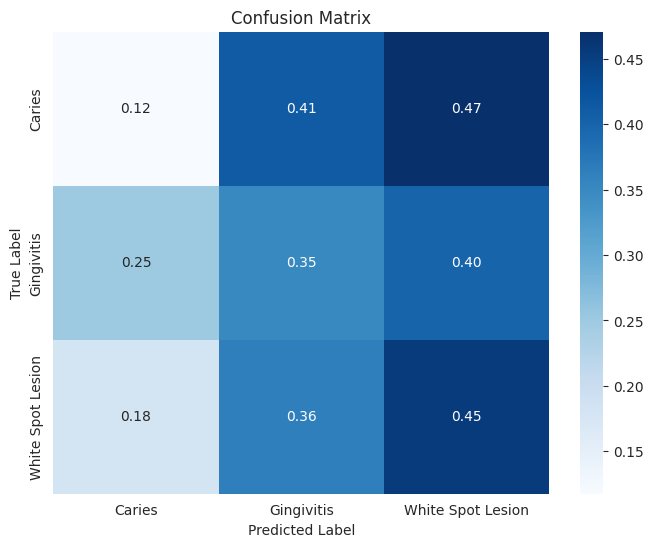

In [28]:
# Calculate and plot confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [29]:
# Print classification report
print(classification_report(all_labels, all_predictions, target_names=class_names))

                   precision    recall  f1-score   support

           Caries       0.18      0.12      0.14        17
       Gingivitis       0.32      0.35      0.33        20
White Spot Lesion       0.38      0.45      0.42        22

         accuracy                           0.32        59
        macro avg       0.29      0.31      0.30        59
     weighted avg       0.30      0.32      0.31        59



In [30]:
# Plotting the training history (optional)
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

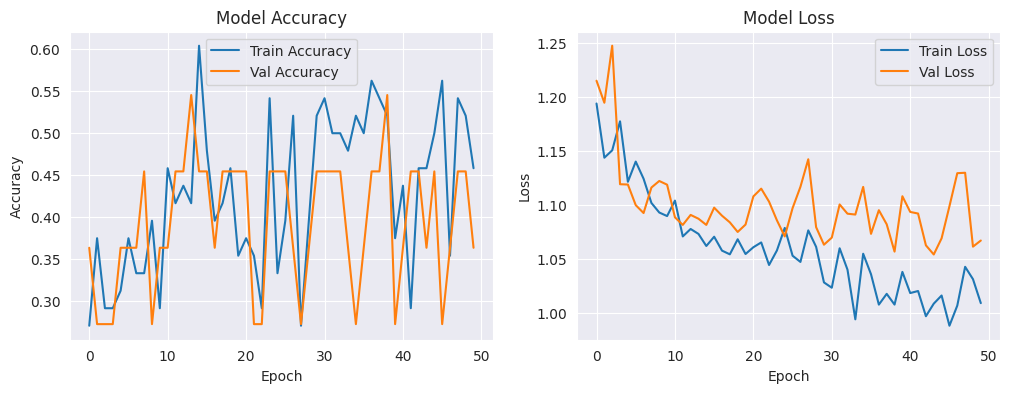

In [31]:
# Plotting the training history (optional)
plot_training_history(history)